In [1]:
# regmetrics - adjust for resample periodicity
# add up/down confusion matrix
# feature scaling in pipeline(trim extremes in X)
# trest ewma function for weighted lagged regressors - perhaps in pipeline
# biforcate by vix and vvix into four samples - build regression model for each one
# BVAR http://apps.eui.eu/Personal/Canova/Articles/ch10.pdf

In [2]:
#IMPORT RELAVENT PYTHON AND SKLEARN LIBRARIES 

#import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning) 

from __future__ import print_function
import datetime
from datetime import date, timedelta
import time
from time import gmtime, strftime

from sklearn.metrics import mean_squared_error as rmse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as evs
from sklearn.metrics import r2_score as r_squared
from sklearn.preprocessing import maxabs_scale
from sklearn.preprocessing import Binarizer as binarizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import mixture
from sklearn.decomposition import FastICA, PCA
from sklearn.linear_model import LinearRegression as linreg
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
import statsmodels 
from statsmodels.graphics.api import qqplot

import statsmodels.api as sm
import statsmodels.tsa.api as ts
from statsmodels.formula.api import ols
import statsmodels.regression.linear_model as smlm
import itertools

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 8.0)

#import cufflinks as cf
#cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
from scipy import stats
#scipy.stats.mstats.winsorize(a, limits=None, inclusive=(True, True), inplace=False, axis=None)[source]
import numpy as np
import pandas as pd
from pandas.core import datetools
pd.set_option('precision', 4)
np.set_printoptions(precision=4)
pd.set_option('colheader_justify', 'right')
from pandas import Series
#import renders as rs
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline
from patsy import dmatrices

#import quandl
#quandl.ApiConfig.api_key = "rhR1sY9oEwWCCtyyBPrN"
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

ImportError: No module named scipy

In [3]:
# SET KEYLINE TIME RELATED PARAMETERS
tranges = {}
tranges['z_score_window'] = 252
tranges['regression_est_window'] = 400
#tranges['tscale'] = ['M','W','D']
tranges['sim_time'] = time.strftime('%x %X')
tranges['trim_pct'] = .01
print(tranges['sim_time'])

08/20/18 13:24:05


In [4]:
# FUNCTION FOR TIME-SAFE Z-SCORES
def z_score(dl,window = tranges['z_score_window']):
    window = tranges['z_score_window']
    rstd = pd.rolling_std(dl,window=window,min_periods=window)
    rmean = pd.rolling_mean(dl,window=window,min_periods=window)
    z = (dl - rmean) / rstd
    z = z.dropna()
    return z


In [5]:
# FUNCTION FOR CUMMULATING LOG RETURNS TO A 'NAV' OR ASSET LEVEL
def rebase_rets(input):
    output = pd.DataFrame(input).set_index(pd.DatetimeIndex(input.index))
    output = output.dropna()
    output = 1+output.cumsum()
    return output

In [6]:
# IMPORT DATASETS FROM QUANDL - THEN RE-USE VIA SAVED CSV
# COMPUTE DIFFERENCE OF LOGS
# APPLY TIME-SAFE Z-SCORE

#macro = quandl.get(["NSE/OIL.1", "CBOE/VIX.4","CBOE/VVIX","YAHOO/INDEX_SPY.6"])
#pd.write_csv('macro')
macro = pd.read_csv('macro.csv')
macro.set_index(pd.DatetimeIndex(macro['Date']), inplace=True)
macro = macro.drop('Date',axis=1)
poil = macro['oil']
pvix = macro['vix']
pvvix = macro['vvix']
spy = macro['spy']

spy = pd.read_csv('spy.csv')
spy.set_index(pd.DatetimeIndex(spy['Date']), inplace=True)
spy = spy.drop('Date',axis=1)
spy.columns = ['spy']

spyders = pd.read_csv('spyders.csv')
spyders.set_index(pd.DatetimeIndex(spyders['Date']), inplace=True)
spyders = spyders.drop('Date',axis=1)

spyders = pd.concat([spyders, spy], axis=1, join='inner').dropna()
#print(spyders)
lspyders = np.log(spyders)
#lspyders = np.log(spyders).resample('M').last()
#print(lspyders)
dl_spyders = lspyders - lspyders.shift()
#print(dl_spyders)
dl_spyders.dropna(inplace=True)

xlf = dl_spyders['xlf']
xle = dl_spyders['xle']
xlk = dl_spyders['xlk']
xly = dl_spyders['xly']
xlp = dl_spyders['xlp']
xlv = dl_spyders['xlv']
xlu = dl_spyders['xlu']
xli = dl_spyders['xli']
xlb = dl_spyders['xlb']
spy = dl_spyders['spy']
dl  = dl_spyders



dlz = z_score(dl,tranges['z_score_window'])


In [7]:
#DATA ANALYSIS - PRINT RAW DATA
spyders

,xlf,xly,xlp,xlb,xlu,xlk,xle,xli,xlv,spy
Date,,,,,,,,,,
2000-01-03,16.3659,24.6966,15.7681,17.5866,15.0350,45.7724,19.8395,21.4162,24.0592,106.9868
2000-01-04,15.6505,23.9536,15.3241,17.4173,14.5815,43.4503,19.4660,20.8245,23.5133,102.8029
2000-01-05,15.5275,23.6590,15.5948,18.1369,14.9495,42.8052,19.9795,20.7317,23.3023,102.9869
2000-01-06,16.2094,23.9280,15.8872,18.6025,14.9238,41.3861,20.7497,21.0101,23.3768,101.3317
2000-01-07,16.4777,25.0552,16.8944,18.5919,15.0522,42.1086,20.9715,21.8106,23.6622,107.2167
2000-01-10,16.1870,24.9271,16.5153,18.5284,15.1035,43.7083,20.7964,21.8106,26.0817,107.5845
2000-01-11,15.9187,24.7862,16.5153,18.3062,14.9409,42.4698,20.8198,21.5322,25.3869,106.2971
2000-01-12,16.2318,24.6453,16.6020,18.0416,14.7869,42.2892,20.7264,21.2769,24.9650,105.2397
2000-01-13,16.7236,24.7734,16.6886,18.1157,14.6500,42.6762,21.0882,21.6830,25.7095,106.6650


In [8]:
# BUILD INITIAL REGRESSOR MATRICES WITH REGRESSORS LAGGED ONE DAY

#Compute difference of log (DL) regressors

y, X = dmatrices('spy ~ xlf.shift(1) + xly.shift(1) + xlp.shift(1) + xlb.shift(1) + xlu.shift(1) \
+ xle.shift(1) + xlk.shift(1) + xli.shift(1) + xlv.shift(1)', data=dl, return_type='dataframe')
del X['Intercept']


#Compute z-scored (DLZ) regressors

yz, Xz = dmatrices('spy ~ dlz.xlf.shift(1) + dlz.xly.shift(1) + dlz.xlp.shift(1) + dlz.xlb.shift(1) \
+ dlz.xlu.shift(1) + dlz.xle.shift(1) + xlk.shift(1) + xli.shift(1) + xlv.shift(1)',data=dlz, return_type='dataframe')
del Xz['Intercept']


#Compute random prediction benchmark

X_bench = pd.DataFrame(np.random.choice([1,-1],size=(len(y.index),1)),columns=['Random'],index=y.index)


In [9]:
# shrink data for code testing
#X = X['2012':'2013']
#Xz = Xz['2012':'2013']
#y = y['2012':'2013']

In [10]:
# ROLL FORWARD LINEAR REGRESSION FUNCTION - TRAIN UP TO T-1 WHEN PREDICTING T

def rreg(X,y,window=tranges['regression_est_window'],drop_pred_indercept = True):
    y = y[min(X.index).date():max(X.index).date()]
    #print(y)
    actual, forc, r2, tstat = {}, {}, {}, {}
    idx = pd.DatetimeIndex(X.index)
    freq = 1
    ttt = [idx[(freq * n):(window + freq * n)] for n in range(int(len(idx) / freq))]
    tt = list(filter(lambda x: len(x)==window, ttt))
    tt = tt[:len(tt)-1]
    fdx = []
    
    for i in range(len(tt)-1):
        if len(tt[i]) == window:

            fit_X = X.ix[tt[i]]
            fit_y = y.ix[tt[i]]
            #print(fit_y)

            next_date = X.index[X.index.get_loc(fit_X.index.max())+1].date()
            pred_X = pd.DataFrame(X.loc[next_date]).T
            act_y = y.loc[next_date].T.values[0]
           
            model = smlm.OLS(fit_y,fit_X).fit()
            rcoeff = model.params
            
            if drop_pred_indercept == True:
                rcoeff = rcoeff.drop('Intercept')
                pred_X = pred_X.drop('Intercept', 1)
            
            pred_y = np.vdot(rcoeff,pred_X)
            
            actual[next_date] = act_y
            forc[next_date] = pred_y
            
            #r2[next_date] = model.rsquared
            #tstat[next_date] = model.tvalues
            
    reg_out = pd.concat([pd.Series(forc,name='predicted'), pd.Series(actual, name='actual')], axis=1).set_index(pd.DatetimeIndex(sorted(actual.keys())))
    
    return reg_out

In [11]:
# ROLL FORWARD PIPELINE FOR DIMENSION REDUCTION -> LINEAR REGRESSION -> ROLL FORWARD TRAINING/PREDICTION

dims_dict = {}
steps = []
def dim_reg(X,y,window=tranges['regression_est_window'],dims_dict = dims_dict,steps=steps):
    y = y[min(X.index).date():max(X.index).date()]
    actual, forc, r2, tstat = {}, {}, {}, {}
    idx = pd.DatetimeIndex(X.index)
    ttt = [idx[(1 * n):(window + n)] for n in range(int(len(idx)))]
    tt = list(filter(lambda x: len(x)==window, ttt))
    tt = tt[:len(tt)-1]
    fdx = []
    
    pipe = Pipeline(steps=steps)
    pipe.set_params(**dims_dict)
        
    for i in range(len(tt)-1):
            
        if len(tt[i]) == window:
            fit_X = X.ix[tt[i]]
            fit_y = y.ix[tt[i]]
            next_date = X.index[X.index.get_loc(fit_X.index.max())+1].date()
            pred_X = pd.DataFrame(X.loc[next_date]).T
            act_y = y.loc[next_date].T.values[0]
            pipe.fit(fit_X,fit_y)
            actual[next_date] = act_y
            forc[next_date] = pipe.predict(pred_X)[0][0]
            
    reg_out = pd.concat([pd.Series(forc,name='predicted'), pd.Series(actual, name='actual')], axis=1).set_index(pd.DatetimeIndex(sorted(actual.keys())))
    
    return reg_out

In [12]:
# TRADING FUNCTION - APPLIES A TRADING RULE TO A PREDICTED RETURN AND STORES RESULTING PERFORMANCE
def tfunc(row):
    #print(row.columns)
    threshold = .00000000000001
    if row['predicted'] > 0 + threshold:
        return row['actual']
    elif row['predicted'] < 0 - threshold:
        return row['actual'] * -1
    else:
        return row['actual'] * 0
    #print(row)

In [13]:
# TRADING RULE - GENERATES ROLL FORWARD OUT OF SAMPLE RETUNRS USING THE TRADING FUNCTION
def trule(results,rule='simple'):
    test = pd.DataFrame()
    oosrets = pd.DataFrame()
    if rule == 'simple': 
        #results['strat_ret'] = np.sign(results.predicted)*results.actual
        results['strat_ret'] = results.apply(tfunc, axis=1)
    results['strat_nav'] = 1+results.strat_ret.cumsum() - 1
    results['act_nav'] = 1+results.actual.cumsum() - 1
    oosrets['strat_ret'] = results.strat_ret
    oosrets['strat_nav'] = results.strat_nav
    oosrets['predicted'] = results.predicted
    oosrets['actual_nav'] = results.act_nav
    oosrets['spy_ret'] = results.actual
    return results, oosrets



In [14]:
# REGRESSION METRICS - USING reg_out FROM THE REGG AND trade_out FROM THE TRULE, 
#                     GENERATES SUMMARY PERFORMANCE STATISTICS AND STORES THEM AS A DATAFRAME COLUMN
                     
def regmetrics(reg_out,trade_out,testlabel):
    #pf = len(reg_out['2002'])
    #print('pf=',pf,reg_out['2013'].index)
    rmse_ = np.sqrt(rmse(reg_out.predicted,reg_out.actual))
    mae_ = mae(reg_out.predicted,reg_out.actual)
    evs_ = evs(reg_out.predicted,reg_out.actual)
    r2_ = r_squared(reg_out.predicted,reg_out.actual)
    mean = 252*trade_out.strat_ret.mean()
    stdev = (np.sqrt(252))*trade_out.strat_ret.std()
    sharpe = mean / stdev
    bench_ret = 252*reg_out.actual.mean()
    bench_std = (np.sqrt(252))*reg_out.actual.std()
    bench_shp = bench_ret / bench_std
    d = {'rmse':rmse_,'mae':mae_,'evs':evs_,'R^2 OOS':r2_,'sharpe':sharpe,'return':mean,'stdev':stdev,'bench_ret':bench_ret,'bench_std':bench_std,'bench_shp':bench_shp}
    d['beg_pred'] = min(reg_out.actual.index).date()
    d['end_pred'] = max(reg_out.actual.index).date()
    d['est window'] = window=tranges['regression_est_window'] 
    d['z window'] = tranges['z_score_window']
    d['sim_time'] = tranges['sim_time']
    #d['r2 IS'] = reg_out.r2is.mean()
    output = pd.DataFrame(d.values(),columns=[testlabel],index=d.keys())
    #
    return output

In [15]:
# TRADING SIMULATOR
# DATA INPUTES: FEATURE AND TARGET MATRICES, NOTE THAT FEATURES MUST BE LAGGED IN ADVANCE.  TEST DESCRIPTION TAGS.
# PIPELINE SETTINGS AND PARAMETERS ARE SET HERE
steps=[]
results=pd.DataFrame()
dims_dict = {}
maxdim_param = 'pca__n_components'
maxdim=2
#def simreg2(indep,dep,simname,steps=steps,maxdim=2,window=tranges['regression_est_window'],maxdim_param=maxdim_param ): 
def simreg2(indep,dep,simname,window=tranges['regression_est_window'],dims_dict=dims_dict,steps=steps,maxdim=maxdim,maxdim_param=maxdim_param): 

    tags=[]   
    grets=pd.DataFrame()
    retlist = {}
    #dims_dict = {}
    
    for i in range(maxdim):        
        
        tag = simname + str(i+1)
        tags.append(tag)
        dims_dict[maxdim_param] = i+1
        print(tags[i],'dim level',i+1,'  ',dims_dict)
        reg_out = dim_reg(indep,dep,steps=steps,dims_dict = dims_dict,window=window)
        trade_out, rets = trule(reg_out)
        
        retlist[tags[i]] = rets
        grets[tags[i]] = rets['strat_ret']
        
        sresults = regmetrics(reg_out,trade_out,tags[i])      
        results[tags[i]] = sresults[tags[i]]
        print("Just Finished   ",tags[i])
               
    #gdata['benchmark'] = trade_out.act_nav
    return results, retlist, grets



In [16]:
# Function to generate random guess bets with 50% up and 50% down
# Returns a,b : a = regression metrics and b = df of out of sample predictions and targets
def random_bets(max_trials=50):
    rand_results=pd.DataFrame()
    rand_grets=pd.DataFrame()
    for t in range(max_trials):
        tags = 'Ramdom ' + str(t)
        X_bench = pd.DataFrame(np.random.choice([1,-1],size=(len(y.index),1)),columns=['Random'],index=y.index)
        rand_out = rreg(X_bench,y,drop_pred_indercept = False)
        rand_trade_out, rand_oos  = trule(rand_out)
        col_rand_results = regmetrics(rand_out,rand_trade_out,'tags')
        
        rand_results[tags] = col_rand_results['tags']
        rand_grets[tags] = rand_oos['strat_ret']
    return rand_results, rand_grets

In [17]:
# Function to run Regg(X,y), calc regmetrics on it, and store OOS trading returns
# Returns a,b : a = regression metrics and b = df of out of sample predictions and targets
def run_regg(X,y,simname,drop_pred_indercept = False):
    regg_results=pd.DataFrame()
    regg_grets=pd.DataFrame()
    regg_out = rreg(X,y,drop_pred_indercept = drop_pred_indercept)
    regg_trade_out, regg_oos  = trule(regg_out)
    col_regg_results = regmetrics(regg_out,regg_trade_out,'tags')
        
    regg_results[simname] = col_regg_results['tags']
    regg_grets[simname] = regg_oos['strat_ret']
    return regg_results, regg_grets

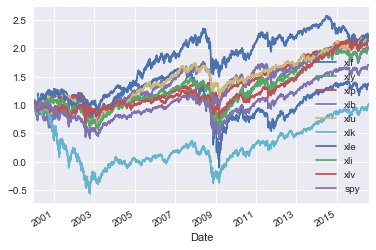

In [18]:
# DATA ANALYSIS - GRAPH OF CUMMULATIVE LOG RETURNS OF RAW SECTOR DATA
import matplotlib.pyplot as plt
rebase_rets(dl).plot()
fig = plt.gcf()
fig.savefig('graph.png')

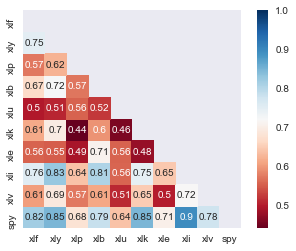

In [19]:
# DATA ANALYSIS - VIEW CORRELATION PROPERTIES BETWEEN SPY AND EACH OF ITS SECTOR COMPONENTS
import seaborn as sns
corr = dl.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap='RdBu')
ax.get_figure().savefig('correl.png')



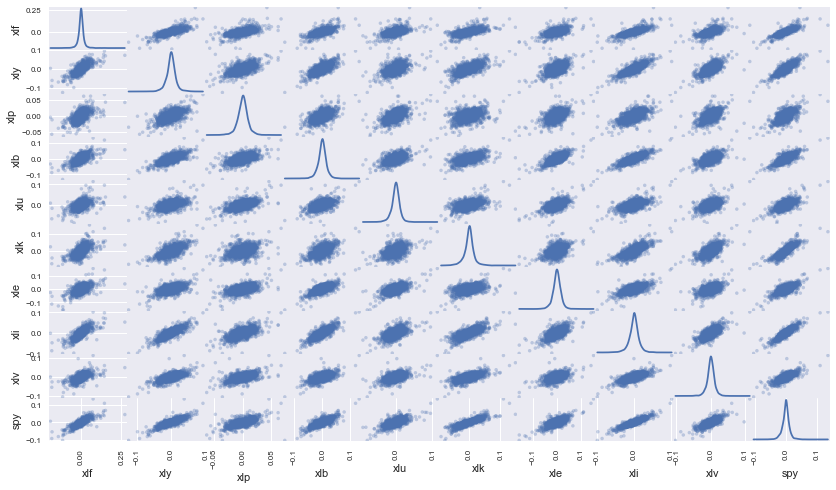

In [20]:
# Data Analysis - scatter matrix for each pair of the Difference of Logs features
pd.scatter_matrix(dl, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
plt.savefig('scatter.png')

DL_PCA 1 dim level 1    {'reg__fit_intercept': True, 'pca__n_components': 1}
Just Finished    DL_PCA 1
DL_PCA 2 dim level 2    {'reg__fit_intercept': True, 'pca__n_components': 2}
Just Finished    DL_PCA 2
DL_PCA 3 dim level 3    {'reg__fit_intercept': True, 'pca__n_components': 3}
Just Finished    DL_PCA 3
DL_PCA 4 dim level 4    {'reg__fit_intercept': True, 'pca__n_components': 4}
Just Finished    DL_PCA 4
DL_PCA 5 dim level 5    {'reg__fit_intercept': True, 'pca__n_components': 5}
Just Finished    DL_PCA 5
DL_PCA 6 dim level 6    {'reg__fit_intercept': True, 'pca__n_components': 6}
Just Finished    DL_PCA 6
DL_PCA 7 dim level 7    {'reg__fit_intercept': True, 'pca__n_components': 7}
Just Finished    DL_PCA 7
DL_PCA 8 dim level 8    {'reg__fit_intercept': True, 'pca__n_components': 8}
Just Finished    DL_PCA 8
DL_PCA 9 dim level 9    {'reg__fit_intercept': True, 'pca__n_components': 9}
Just Finished    DL_PCA 9


,DL_PCA 1,DL_PCA 2,DL_PCA 3,DL_PCA 4,DL_PCA 5,DL_PCA 6,DL_PCA 7,DL_PCA 8,DL_PCA 9
return,0.08738,0.0854,0.06088,0.03378,0.03063,0.06546,0.05432,0.03803,0.06884
z window,252,252,252,252,252,252,252,252,252
mae,0.008198,0.00821,0.008212,0.008225,0.008254,0.008275,0.008299,0.008321,0.008345
stdev,0.1965,0.1965,0.1965,0.1965,0.1965,0.1965,0.1965,0.1965,0.1965
beg_pred,2001-08-07,2001-08-07,2001-08-07,2001-08-07,2001-08-07,2001-08-07,2001-08-07,2001-08-07,2001-08-07
bench_std,0.1965,0.1965,0.1965,0.1965,0.1965,0.1965,0.1965,0.1965,0.1965
R^2 OOS,-94.11,-48.52,-44.42,-38.8,-34.14,-29.08,-25.4,-23.46,-20.76
rmse,0.0124,0.01238,0.01241,0.01244,0.01249,0.01249,0.0125,0.01254,0.01255
end_pred,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04
bench_shp,0.2986,0.2986,0.2986,0.2986,0.2986,0.2986,0.2986,0.2986,0.2986


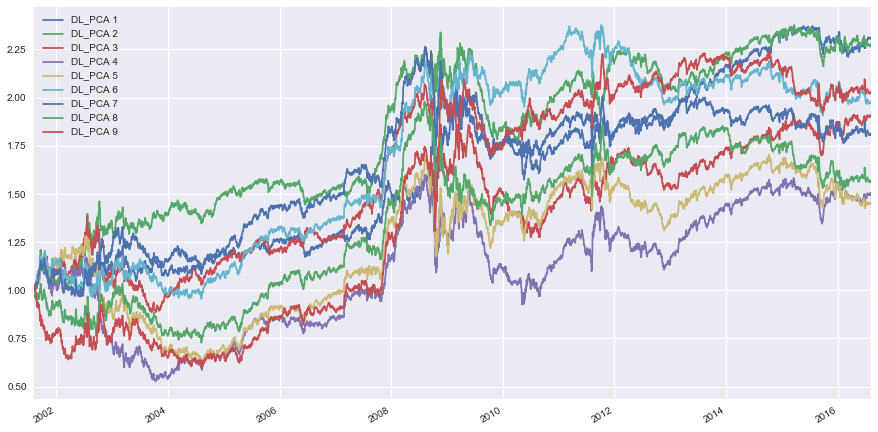

In [21]:
# FINAL WRAPPER SCRIPT FOR TRADING SIMULATOR - APPLIED TO LOG RETURNS (NOT Z-SCORED)
# FOR PIPELINE - NEED TO SET SEQUENCE OF LEARNERS IN steps AND maxdim_param
# COMPUTES SIMULATIONS, GENERATES PERFORMANCE METRICS AND GRAPHS THEM
# THIS CELL HAS NO Z-SCORES ON THE FEATURES
reg = linreg()
pca = PCA()
ica = FastICA()

steps=[('pca', pca), ('reg', reg)]
maxdim_param = 'pca__n_components'
maxdim = 9
simname = 'DL_PCA '
dims_dict = {'reg__fit_intercept':True}
resultsX, retlistX, gretsX = simreg2(indep=X,dep=y,simname=simname,maxdim=maxdim,maxdim_param=maxdim_param,steps=steps,dims_dict=dims_dict)


mtm = rebase_rets(gretsX)
plt.rcParams['figure.figsize'] = (15.0, 8.0)
mtm.plot()
figg = plt.gcf()
figg.savefig('dl_pca.png')
results

DLZ_PCA 1 dim level 1    {'reg__fit_intercept': True, 'pca__n_components': 1}
Just Finished    DLZ_PCA 1
DLZ_PCA 2 dim level 2    {'reg__fit_intercept': True, 'pca__n_components': 2}
Just Finished    DLZ_PCA 2
DLZ_PCA 3 dim level 3    {'reg__fit_intercept': True, 'pca__n_components': 3}
Just Finished    DLZ_PCA 3
DLZ_PCA 4 dim level 4    {'reg__fit_intercept': True, 'pca__n_components': 4}
Just Finished    DLZ_PCA 4
DLZ_PCA 5 dim level 5    {'reg__fit_intercept': True, 'pca__n_components': 5}
Just Finished    DLZ_PCA 5
DLZ_PCA 6 dim level 6    {'reg__fit_intercept': True, 'pca__n_components': 6}
Just Finished    DLZ_PCA 6
DLZ_PCA 7 dim level 7    {'reg__fit_intercept': True, 'pca__n_components': 7}
Just Finished    DLZ_PCA 7
DLZ_PCA 8 dim level 8    {'reg__fit_intercept': True, 'pca__n_components': 8}
Just Finished    DLZ_PCA 8
DLZ_PCA 9 dim level 9    {'reg__fit_intercept': True, 'pca__n_components': 9}
Just Finished    DLZ_PCA 9


,DLZ_PCA 1,DLZ_PCA 2,DLZ_PCA 3,DLZ_PCA 4,DLZ_PCA 5,DLZ_PCA 6,DLZ_PCA 7,DLZ_PCA 8,DLZ_PCA 9
return,0.09709,0.1105,0.072,0.05638,0.06893,0.07939,0.06894,0.006223,0.06051
z window,252,252,252,252,252,252,252,252,252
mae,0.007983,0.007981,0.007999,0.008023,0.008043,0.008063,0.008081,0.008107,0.008108
stdev,0.1931,0.1931,0.1931,0.1932,0.1931,0.1931,0.1931,0.1932,0.1932
beg_pred,2002-08-12,2002-08-12,2002-08-12,2002-08-12,2002-08-12,2002-08-12,2002-08-12,2002-08-12,2002-08-12
bench_std,0.1931,0.1931,0.1931,0.1931,0.1931,0.1931,0.1931,0.1931,0.1931
R^2 OOS,-127.9,-60.7,-54.24,-47.42,-38.49,-35.27,-31.55,-29.33,-27.06
rmse,0.01219,0.01216,0.01219,0.01221,0.0122,0.01224,0.01225,0.01228,0.01228
end_pred,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04
bench_shp,0.4227,0.4227,0.4227,0.4227,0.4227,0.4227,0.4227,0.4227,0.4227


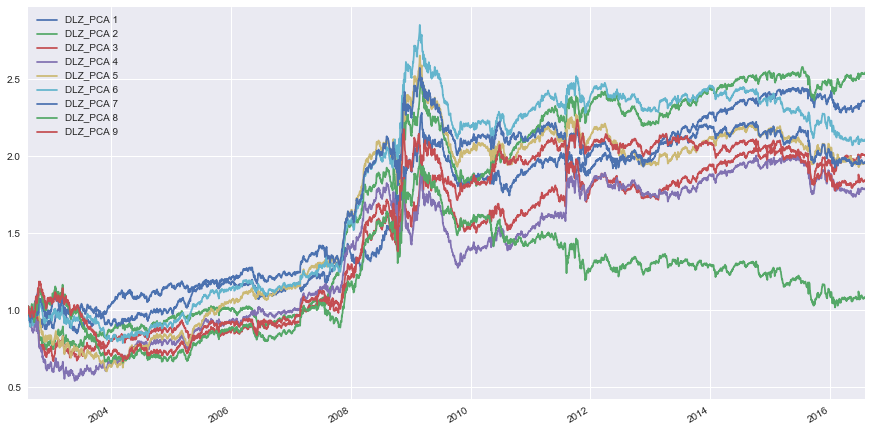

In [22]:
# FINAL WRAPPER SCRIPT FOR TRADING SIMULATOR - APPLIED TO Z-SCORED LOG RETURNS
# FOR PIPELINE - NEED TO SET SEQUENCE OF LEARNERS IN steps AND maxdim_param
# COMPUTES SIMULATIONS, GENERATES PERFORMANCE METRICS AND GRAPHS THEM
# THIS CELL HAS NO Z-SCORES ON THE FEATURES
reg = linreg()
pca = PCA()
ica = FastICA()

# Reset the results df for the next set of tests
results = pd.DataFrame() 

steps=[('pca', pca), ('reg', reg)]
maxdim_param = 'pca__n_components'
maxdim = 9
simname = 'DLZ_PCA '
dims_dict = {'reg__fit_intercept':True}
resultsXz, retlistXz, gretsXz = simreg2(indep=Xz,dep=y,simname=simname,maxdim=maxdim,maxdim_param=maxdim_param,steps=steps,dims_dict=dims_dict)

mtm = rebase_rets(gretsXz)
plt.rcParams['figure.figsize'] = (15.0, 8.0)
mtm.plot()
figg = plt.gcf()
figg.savefig('dl_pca.png')
results

In [ ]:
#
#  this is the end of testing - the rest are summary / diagnostics, some of which run very slowly
#

Average Return when guessing =  0.00265442491079


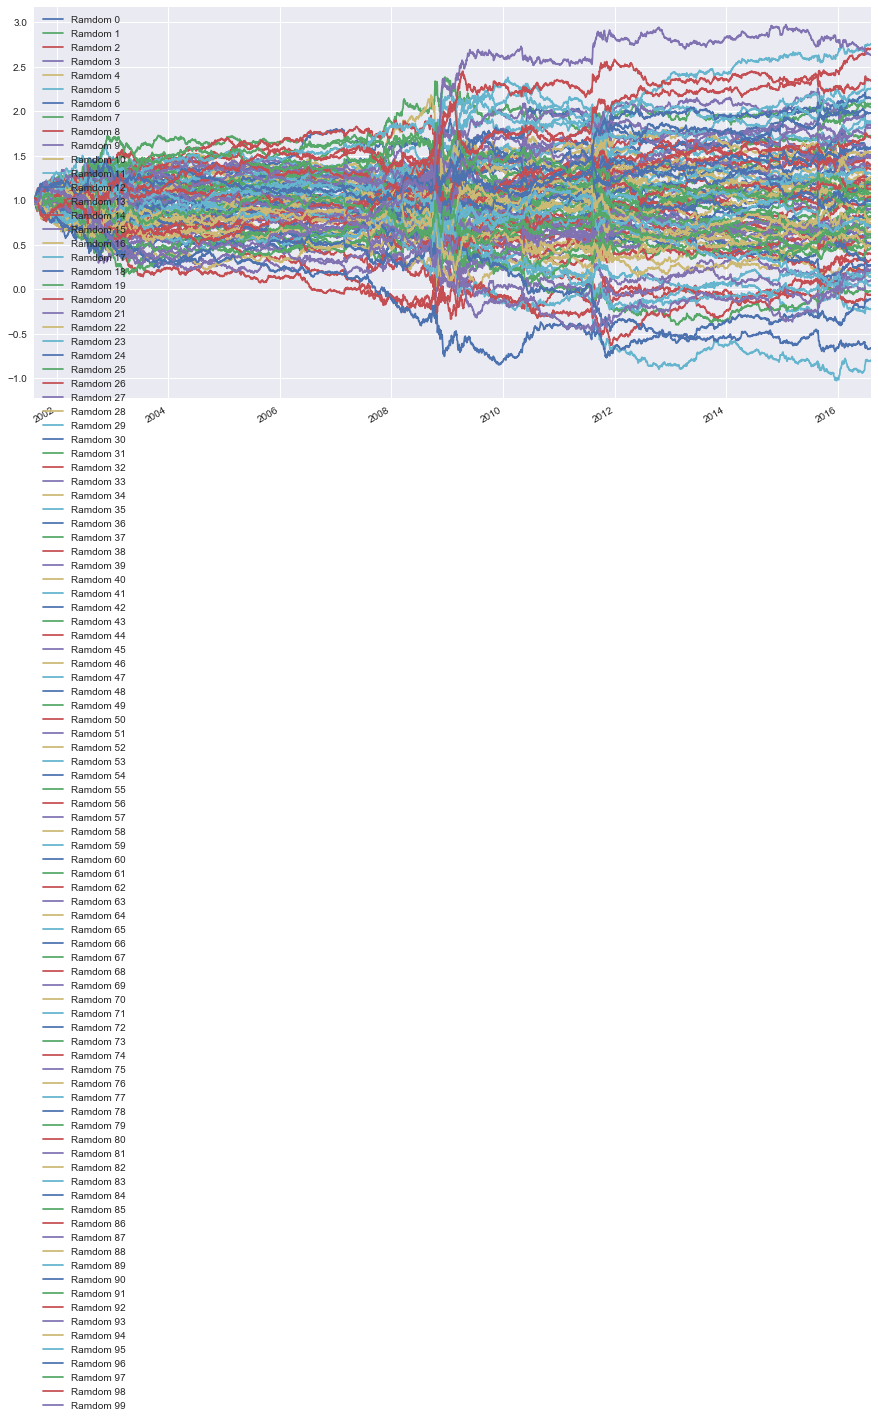

In [23]:
# COMPUTE N RANDOM STRATEGIES (50% up 50% down guess) AND GRAPH PERFOMANCE
a , Rand_Rets = random_bets(100)
c = rebase_rets(Rand_Rets)
print("Average Return when guessing = ", a.T['return'].mean())
c.plot()

In [24]:
a.T['return'].std()

0.046904925001839723

Average Return when guessing =  0.0615167243569


,Non-PCA_Benchmark
return,0.06152
z window,252
mae,0.008355
stdev,0.1965
beg_pred,2001-08-07
bench_std,0.1965
R^2 OOS,-22.07
rmse,0.01254
end_pred,2016-08-04
bench_shp,0.2986


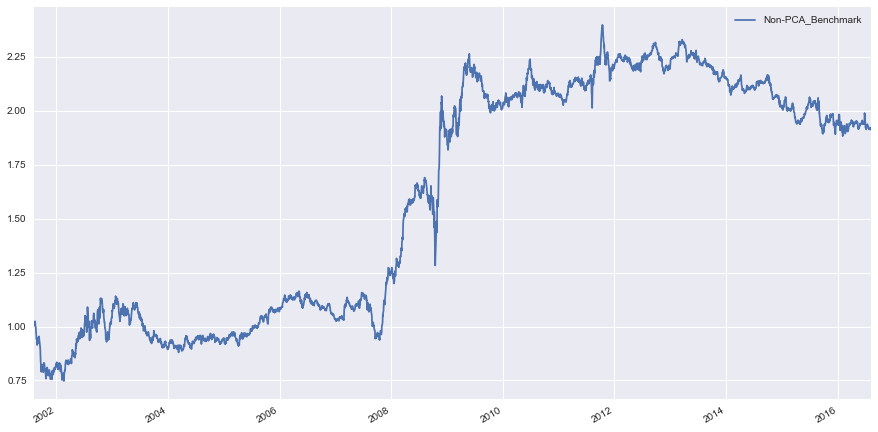

In [25]:
# Benchmark - COMPUTE Non-PCA Benchmark
simname='Non-PCA_Benchmark'
results , Regg_Rets = run_regg(X,y,simname)
c = rebase_rets(Regg_Rets)
print("Average Return when guessing = ", results.T['return'].mean())
c.plot()
results

In [26]:
# Use Statsmodels OLS to get full report on Non-PCA Benchmark Regression
model = smlm.OLS(y,X)
basicm = model.fit()
basicm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     4.299
Date:                Mon, 20 Aug 2018   Prob (F-statistic):           1.39e-05
Time:                        13:46:42   Log-Likelihood:                 12349.
No. Observations:                4173   AIC:                        -2.468e+04
Df Residuals:                    4164   BIC:                        -2.462e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
xlf.shift(1)    -0.0199      0.016     -1.266      0.206      -0.051       0.011
xly.shift(1)     0.0866      0.027      3.223      0.001       0.034       0.139
xlp.shift(1)     0.0460      0.029      1.562      0.118      -0.012       0.104
xlb.shift(1)    -0.0049      0.023     -0.213      0.832      -0.051       0.041
xlu.shift(1)    -0.0256      0.022     -1.187      0.235      -0.068       0.017
xle.shift(1)    -0.0345      0.016     -2.105      0.035      -0.067      -0.002
xlk.shift(1)     0.0098      0.019      0.524      0.601      -0.027       0.046
xli.shift(1)    -0.0464      0.034     -1.347      0.178      -0.114       0.021
xlv.shift(1)    -0.0626      0.026     -2.398      0.017      -0.114      -0.011
==============================================================================
Omnibus:                      712.866   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14405.440
Skew:                          -0.150   Prob(JB):                         0.00
Kurtosis:                      12.097   Cond. No.                         7.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
## EXTRACT PIPELINE ATTRIBUES - FOR PCA, Build explained variance ration series, FOR REGRESSION, STORE COEFF'S IN SERIES
dims_dict = {}
steps = []
reg = linreg()
pca = PCA()
ica = FastICA()
def pipe_attributes(X,window=tranges['regression_est_window'],dims_dict = dims_dict,steps=steps):
    #y = y[min(X.index).date():max(X.index).date()]
    actual, forc, r2, tstat, ratio, coeffs = {}, {}, {}, {}, {},{}
    idx = pd.DatetimeIndex(X.index)
    ttt = [idx[(1 * n):(window + n)] for n in range(int(len(idx)))]
    tt = filter(lambda x: len(x)==window, ttt)
    tt = tt[:len(tt)-1]
    fdx = []
    steps=[('pca', pca),('reg', reg)]
    pipe = Pipeline(steps=steps)
    pipe.set_params(**dims_dict)
    #ratio    
    for i in range(len(tt)-1):
            
        if len(tt[i]) == window:
            fit_X = X.ix[tt[i]]
            fit_y = y.ix[tt[i]]
            next_date = X.index[X.index.get_loc(fit_X.index.max())+1].date()
            pred_X = pd.DataFrame(X.loc[next_date]).T
            #act_y = y.loc[next_date].T.values[0]
            pipe.fit(fit_X,fit_y)
            #pipe.fit(fit_X,fit_y)
            ratio[next_date] = pipe.named_steps['pca'].explained_variance_ratio_
            coeffs[next_date] = pipe.named_steps['reg'].coef_[0]
            actual[next_date] = X.loc[next_date].T.values[0]
            #forc[next_date] = pipe.predict(pred_X)[0][0]
            
    #pca_out = pd.concat([pd.Series(ratio,name='pca_variance ratio')], axis=1).set_index(pd.DatetimeIndex(sorted(actual.keys())))
    #reg_coeffs = pd.concat([pd.Series(coeffs,name='regression_coefficients')], axis=1).set_index(pd.DatetimeIndex(sorted(actual.keys())))

    return coeffs, ratio
#pipe.named_steps['pca'].get_support()

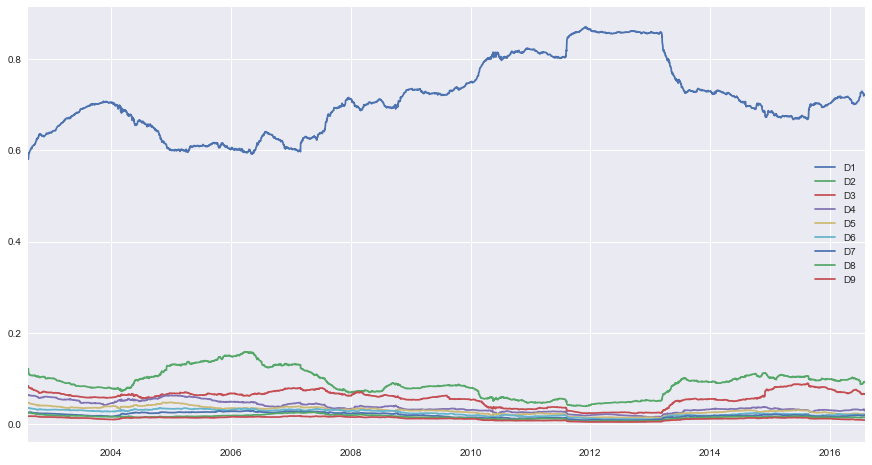

In [28]:
# Data Visualization - Capture coefficients and explained variance ratio for each rolling training window

dims_dict = {maxdim_param : 9} 
coeffs,pca_ratio = pipe_attributes(Xz,dims_dict=dims_dict)
variance_pct = pd.DataFrame(pca_ratio).T
variance_pct.columns = ['D1','D2','D3','D4','D5','D6','D7','D8','D9']
variance_pct.plot()

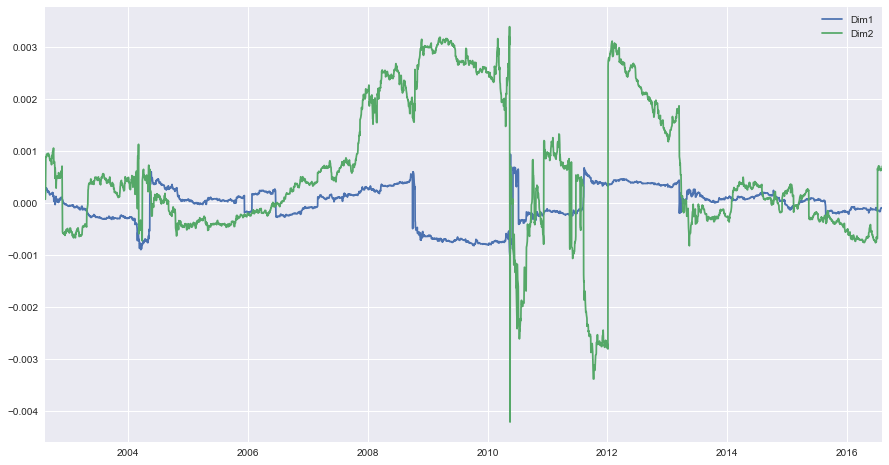

In [29]:
# Data Visualization - Capture the regression coefficients when two dimensions are passed on as features.
dims_dict = {maxdim_param : 2} 
coeffs,pca_ratio = pipe_attributes(Xz,dims_dict=dims_dict)
tt = pd.DataFrame.from_dict(coeffs).T
tt.columns = ['Dim1','Dim2']
tt.plot()

In [30]:
# Refinement - Window Range Simulator for a FIXED number of PCA dimensions
# DATA INPUTES: FEATURE AND TARGET MATRICES, NOTE THAT FEATURES MUST BE LAGGED IN ADVANCE.
# PIPELINE SETTINGS AND PARAMETERS ARE SET HERE

results=pd.DataFrame()
#dims_dict = {}
maxdim_param = 'pca__n_components'
def sim_windows(indep,dep,simname,steps=steps,minwindow = 60,maxwindow=400,increment = 5,window=tranges['regression_est_window'],pcadims = 2 ): 
    tags=[]   
    grets=pd.DataFrame()
    retlist = {}
    dims_dict = {}
    spot = -1
    for t_window in range(minwindow,maxwindow,increment):        
        spot = spot +1
        tag = simname + str(t_window)
        tags.append(tag)
        dims_dict = {maxdim_param : pcadims} 
        print(tags[spot],'window',t_window)
        reg_out = dim_reg(indep,dep,steps=steps,dims_dict = dims_dict,window=t_window)
        trade_out, rets = trule(reg_out)
        
        retlist[tags[spot]] = rets
        grets[tags[spot]] = rets['strat_ret']
        
        sresults = regmetrics(reg_out,trade_out,tags[spot])      
        results[tags[spot]] = sresults[tags[spot]]
        print("Just Finished   ",tags[spot])
               
    #gdata['benchmark'] = trade_out.act_nav
    return results, retlist, grets



Window= 50 window 50
Just Finished    Window= 50
Window= 52 window 52
Just Finished    Window= 52
Window= 54 window 54
Just Finished    Window= 54
Window= 56 window 56
Just Finished    Window= 56
Window= 58 window 58
Just Finished    Window= 58
Window= 60 window 60
Just Finished    Window= 60
Window= 62 window 62
Just Finished    Window= 62
Window= 64 window 64
Just Finished    Window= 64
Window= 66 window 66
Just Finished    Window= 66
Window= 68 window 68
Just Finished    Window= 68
Window= 70 window 70
Just Finished    Window= 70
Window= 72 window 72
Just Finished    Window= 72
Window= 74 window 74
Just Finished    Window= 74
Window= 76 window 76
Just Finished    Window= 76
Window= 78 window 78
Just Finished    Window= 78
Window= 80 window 80
Just Finished    Window= 80
Window= 82 window 82
Just Finished    Window= 82
Window= 84 window 84
Just Finished    Window= 84
Window= 86 window 86
Just Finished    Window= 86
Window= 88 window 88
Just Finished    Window= 88
Window= 90 window 90

,Window= 50,Window= 52,Window= 54,Window= 56,Window= 58,Window= 60,Window= 62,Window= 64,Window= 66,Window= 68,...,Window= 780,Window= 782,Window= 784,Window= 786,Window= 788,Window= 790,Window= 792,Window= 794,Window= 796,Window= 798
return,0.009094,-0.004226,-0.02213,0.01523,0.04066,0.02424,0.01996,0.001974,0.0593,0.05948,...,0.08465,0.08756,0.07822,0.08415,0.09173,0.09158,0.08678,0.09882,0.1047,0.08712
z window,252,252,252,252,252,252,252,252,252,252,...,252,252,252,252,252,252,252,252,252,252
mae,0.008467,0.008448,0.008431,0.008414,0.008375,0.008392,0.008394,0.008381,0.00836,0.008348,...,0.007812,0.007815,0.007816,0.007819,0.00782,0.007824,0.007824,0.007826,0.007826,0.007827
stdev,0.197,0.197,0.1968,0.1967,0.1967,0.1966,0.1965,0.1964,0.1962,0.1961,...,0.1924,0.1925,0.1925,0.1926,0.1926,0.1927,0.1927,0.1928,0.1928,0.1928
beg_pred,2001-03-16,2001-03-20,2001-03-22,2001-03-26,2001-03-28,2001-03-30,2001-04-03,2001-04-05,2001-04-09,2001-04-11,...,2004-02-13,2004-02-18,2004-02-20,2004-02-24,2004-02-26,2004-03-01,2004-03-03,2004-03-05,2004-03-09,2004-03-11
bench_std,0.197,0.1969,0.1968,0.1967,0.1966,0.1966,0.1965,0.1964,0.1962,0.1961,...,0.1925,0.1925,0.1926,0.1926,0.1927,0.1927,0.1928,0.1928,0.1929,0.1929
R^2 OOS,-16.27,-17.05,-17.61,-18.02,-18.64,-19.12,-19.81,-20.14,-20.61,-20.86,...,-78.41,-78.66,-79.08,-79.02,-79.03,-79.29,-79.6,-79.78,-79.8,-79.78
rmse,0.01272,0.01269,0.01268,0.01267,0.01263,0.01265,0.01264,0.01262,0.01258,0.01258,...,0.0121,0.01211,0.01211,0.01212,0.01212,0.01212,0.01212,0.01213,0.01213,0.01213
end_pred,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,...,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04,2016-08-04
bench_shp,0.2993,0.2996,0.3147,0.3085,0.2978,0.3061,0.3101,0.3204,0.3136,0.3041,...,0.3662,0.3645,0.368,0.3705,0.3696,0.3692,0.3677,0.3659,0.3699,0.3789


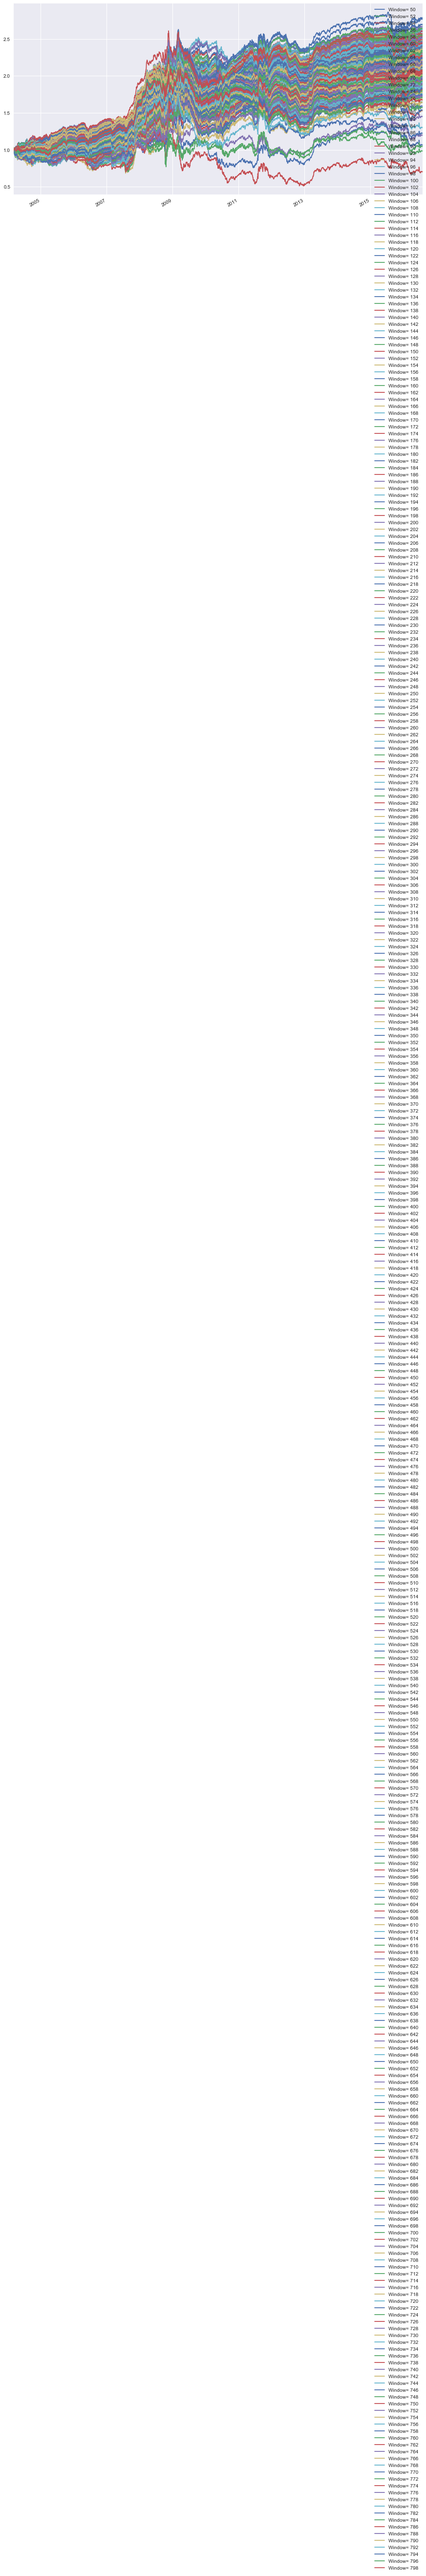

In [31]:
# FINAL WRAPPER SCRIPT FOR Window Range SIMULATOR
reg = linreg()
pca = PCA()
ica = FastICA()
 
steps=[('pca', pca), ('reg', reg)]
maxdim_param = 'pca__n_components'
pcadims = 2
simname = 'Window= '
minwindow = 50
maxwindow = 800
increment = 50
results, retlist, grets = sim_windows(indep=Xz,dep=y,simname=simname,steps=steps,pcadims=pcadims,minwindow = minwindow,maxwindow=maxwindow,increment = increment)


mtm = rebase_rets(grets)
plt.rcParams['figure.figsize'] = (15.0, 8.0)
mtm.plot()
figg = plt.gcf()
figg.savefig('dl_pca.png')
results

Peak results return    Window= 362
dtype: object with an average return of return    0.1396
dtype: float64


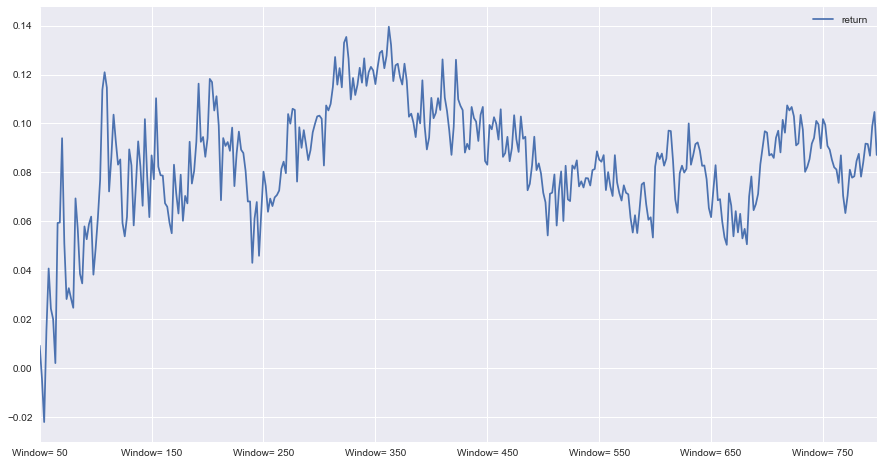

In [32]:
# Extract the Max/Peak return window and plot
tt = results.T['return'].sort_index
dd = pd.DataFrame(results.T['return'])
dd.plot()
print("Peak results",dd.idxmax(),"with an average return of", dd.max())


In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



0
             precision    recall  f1-score   support

         up       0.63      0.66      0.64      1721
       down       0.70      0.67      0.68      2051

avg / total       0.67      0.66      0.66      3772

[[1131  590]
 [ 677 1374]]
Confusion matrix, without normalization
1
             precision    recall  f1-score   support

         up       0.59      0.61      0.60      1721
       down       0.66      0.64      0.65      2051

avg / total       0.63      0.63      0.63      3772

[[1056  665]
 [ 740 1311]]
Confusion matrix, without normalization
2
             precision    recall  f1-score   support

         up       0.56      0.59      0.57      1721
       down       0.64      0.61      0.63      2051

avg / total       0.60      0.60      0.60      3772

[[1010  711]
 [ 793 1258]]
Confusion matrix, without normalization
3
             precision    recall  f1-score   support

         up       0.56      0.60      0.58      1721
       down       0.64      0.61      0

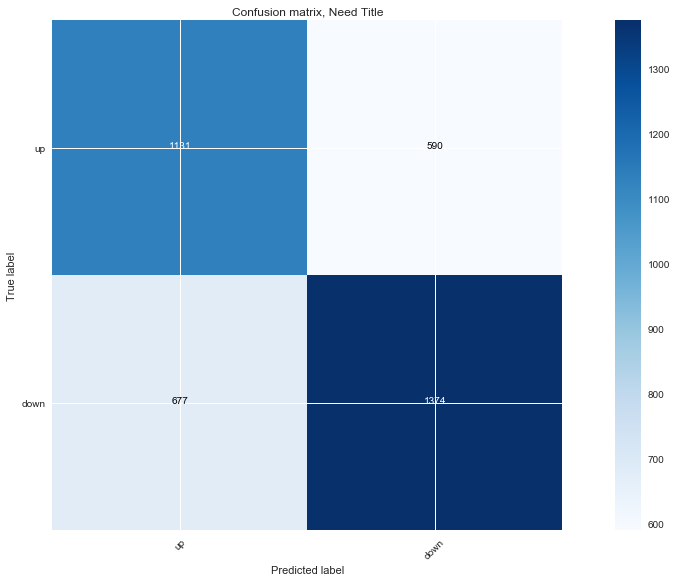

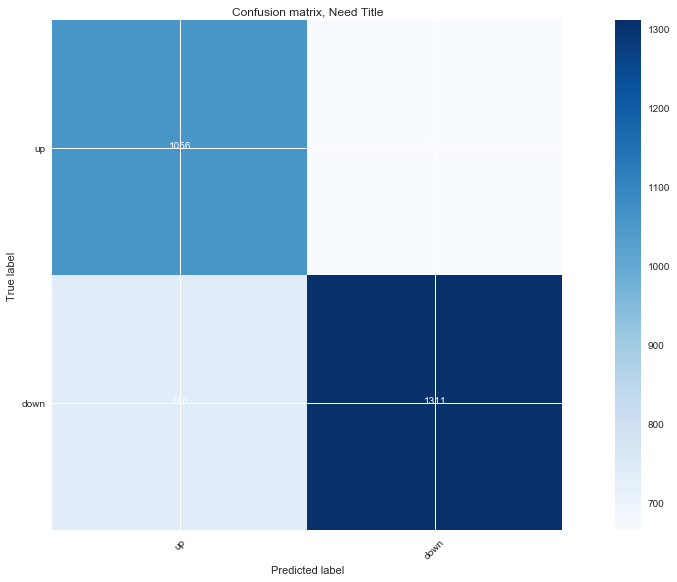

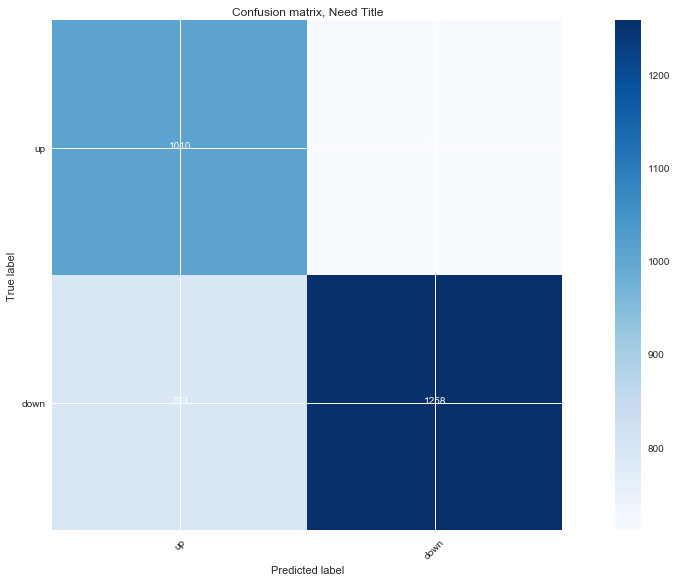

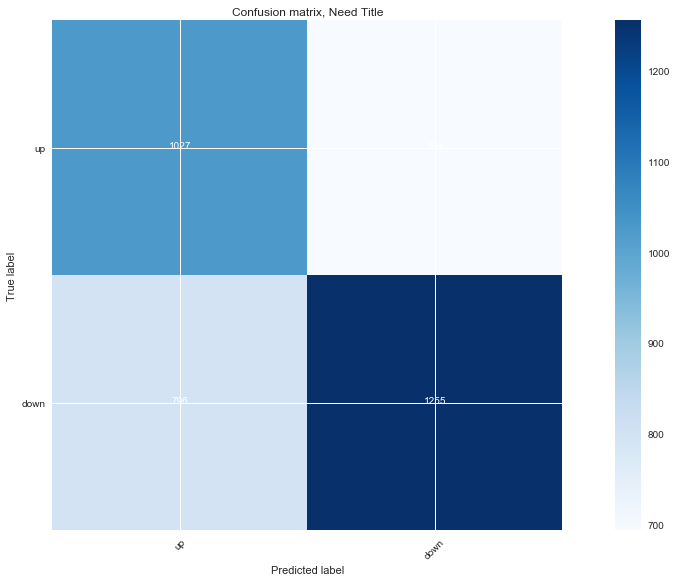

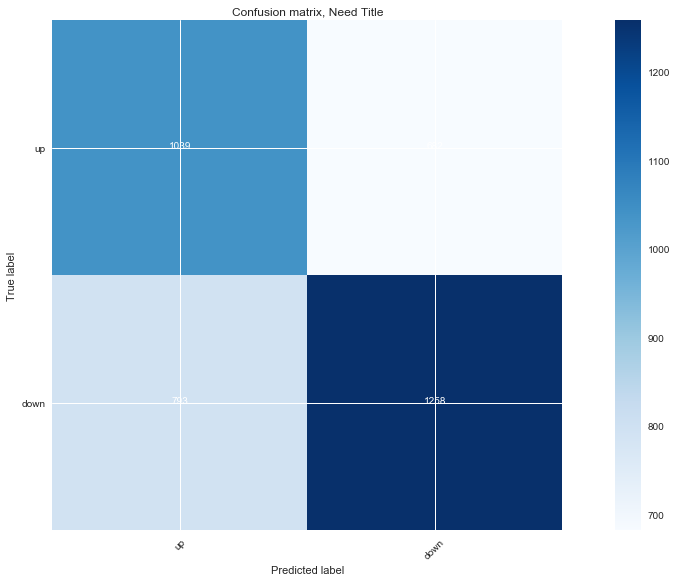

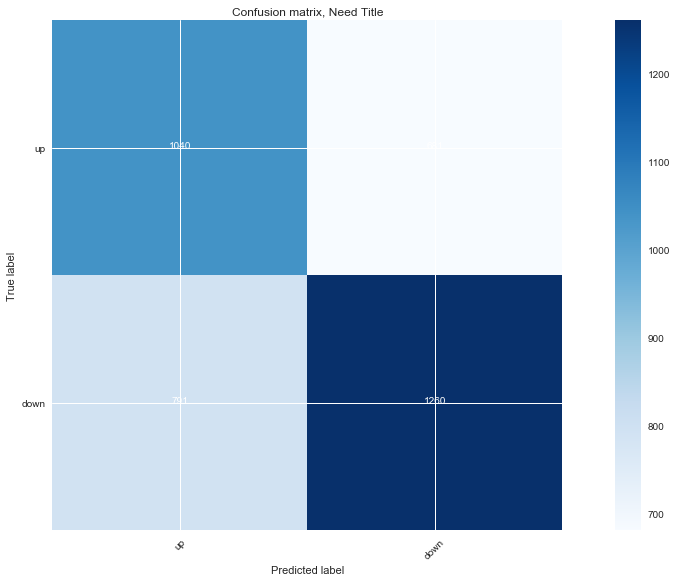

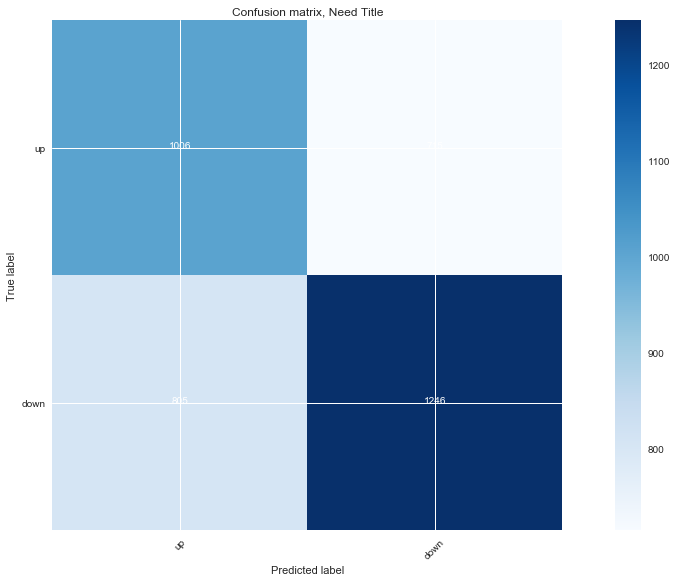

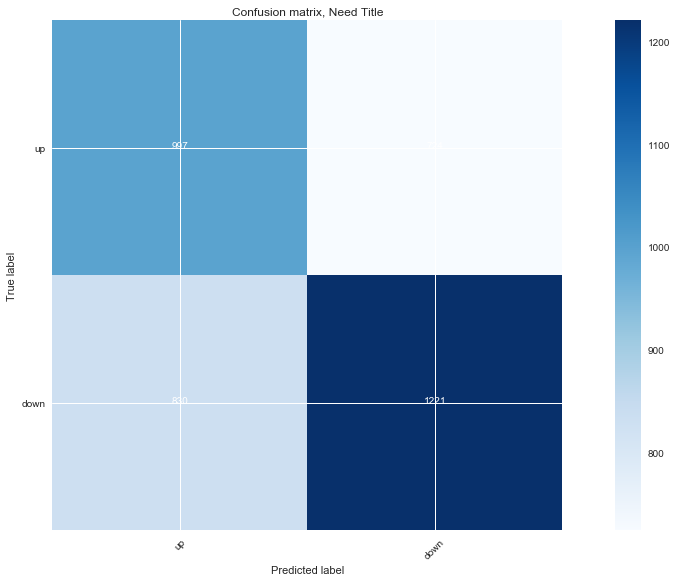

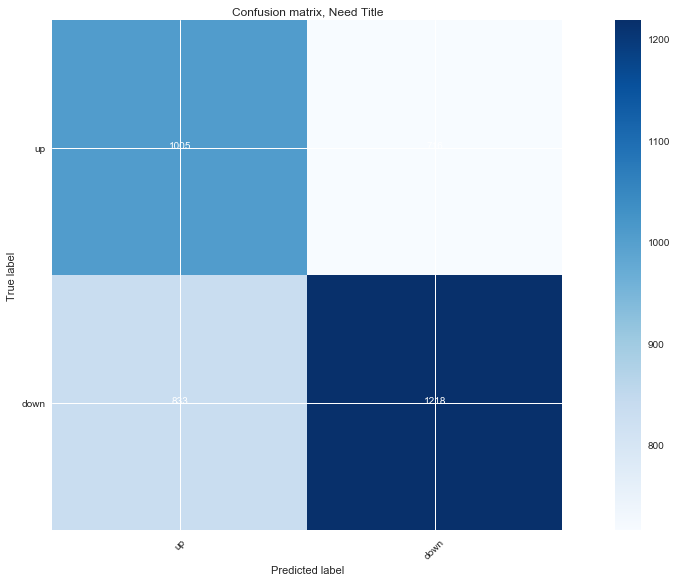

In [41]:
# Classify the results into Up vs Down and then compute Confusion Matrix and Classification Report
#binarizer.__init__(threshold=0.0,copy=True)  # get an instance of the class
binarizer = preprocessing.Binarizer().fit(X)
Xbin = pd.DataFrame(binarizer.fit_transform(gretsX),index=gretsX.index)
ybin = pd.DataFrame(y,index=gretsX.index)
ybin = pd.DataFrame(binarizer.transform(ybin),index=ybin.index)
class_names = ['up','down']
for col in Xbin.columns:
    print(col)
    print(classification_report(ybin,Xbin[col],target_names=class_names))
    #print(col)
    #test = Xbin[col]
    #print(test.tail)
    cfm = confusion_matrix(ybin,Xbin[col])
    print(cfm)
    plt.figure()
    plot_confusion_matrix(cfm, classes=class_names,
                      title='Confusion matrix, Need Title')
    
 

             precision    recall  f1-score   support

         up       0.45      0.48      0.47      1721
       down       0.54      0.51      0.52      2051

avg / total       0.50      0.50      0.50      3772

[[ 834  887]
 [1012 1039]]
Confusion matrix, without normalization
             precision    recall  f1-score   support

         up       0.47      0.49      0.48      1721
       down       0.55      0.53      0.54      2051

avg / total       0.51      0.51      0.51      3772

[[ 851  870]
 [ 973 1078]]
Confusion matrix, without normalization
             precision    recall  f1-score   support

         up       0.46      0.51      0.49      1721
       down       0.55      0.50      0.52      2051

avg / total       0.51      0.51      0.51      3772

[[ 886  835]
 [1027 1024]]
Confusion matrix, without normalization
             precision    recall  f1-score   support

         up       0.46      0.50      0.48      1721
       down       0.55      0.50      0.52     

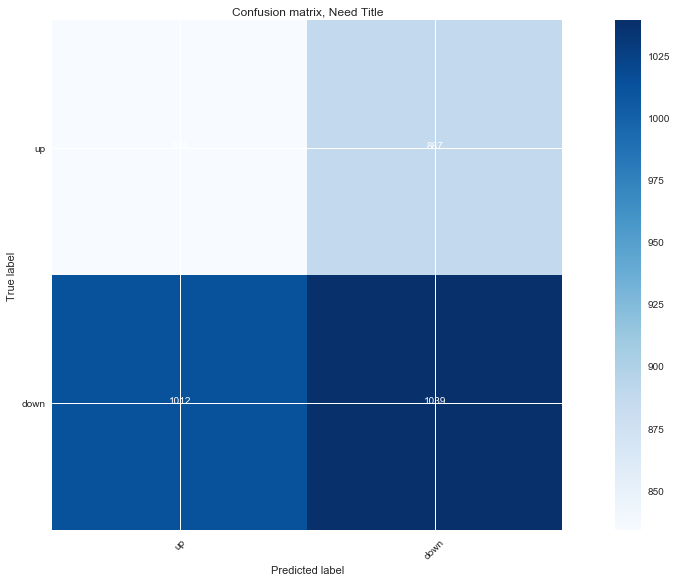

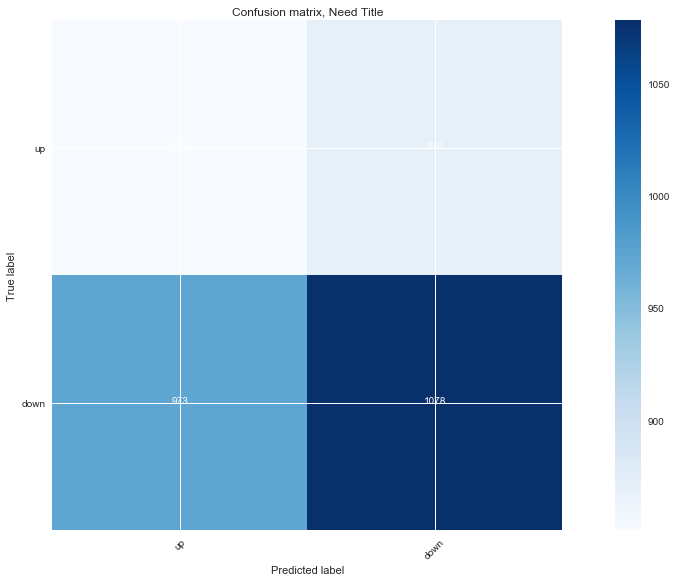

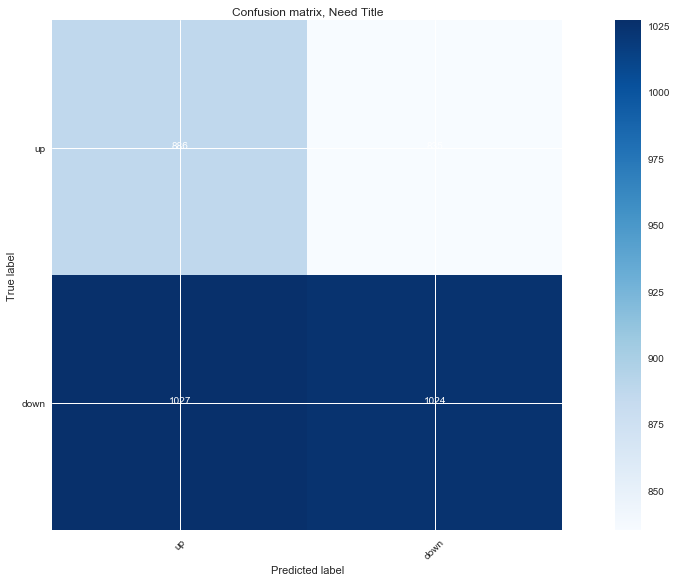

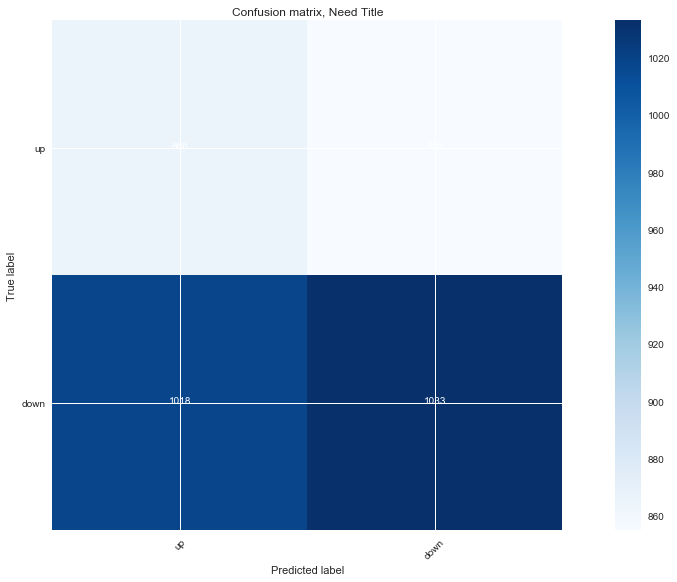

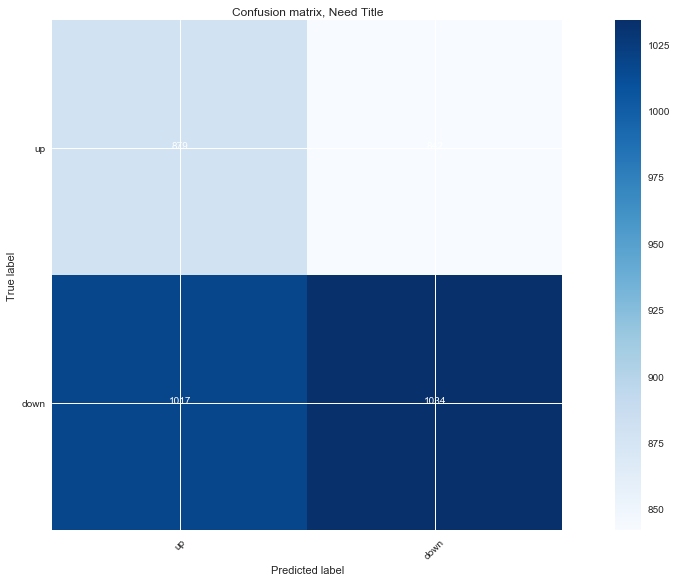

In [42]:
# Classify the Random results into Up vs Down and then compute Confusion Matrix and Classification Report
a , random_rets = random_bets(5)

Xrandbin = pd.DataFrame(binarizer.transform(random_rets),index=random_rets.index)
ybin = pd.DataFrame(y,index=random_rets.index)
ybin = pd.DataFrame(binarizer.transform(ybin),index=ybin.index)
for col in Xrandbin.columns:
    print(classification_report(ybin,Xrandbin[col],target_names=class_names))
    cfm = confusion_matrix(ybin,Xrandbin[col])
    print(cfm)
    plt.figure()
    plot_confusion_matrix(cfm, classes=class_names,
                      title='Confusion matrix, Need Title')


In [43]:
#results.to_csv('Base_DailyTable.csv')
#results.to_pickle('BaseDailyResults')

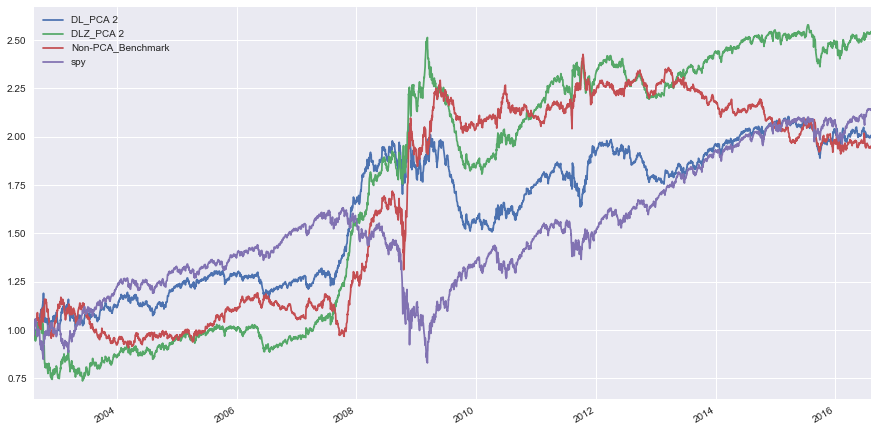

In [44]:
#RESULTS - GRAPH RECOMMENDED MODEL AGAINST NON-PCA BENCHMARK, SPY, AND NON-SCORED FEATURES
final_graph = rebase_rets(pd.concat([gretsX['DL_PCA 2'], gretsXz['DLZ_PCA 2'],Regg_Rets['Non-PCA_Benchmark'],spy], axis=1, join='inner').dropna())
final_graph.plot()
figg = plt.gcf()
figg.savefig('final_graph.png')

In [49]:
final_table = pd.concat([resultsX['DL_PCA 2'], resultsXz['DLZ_PCA 2']], axis=1, join='inner').dropna()

final_table

,DL_PCA 2,DLZ_PCA 2
return,0.0854,0.1105
z window,252,252
mae,0.00821,0.007981
stdev,0.1965,0.1931
beg_pred,2001-08-07,2002-08-12
bench_std,0.1965,0.1931
R^2 OOS,-48.52,-60.7
rmse,0.01238,0.01216
end_pred,2016-08-04,2016-08-04
bench_shp,0.2986,0.4227
